#### SVI data and death data processing

###### American National Standards Institute (ANSI) Codes for States
###### Virginia:VA: 51
###### Maryland:MD: 24
###### West Virginia:WV: 54
###### District of Columbia:DC: 11

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# imoporting SVI data for the entire US(county level) 
us_svi = gpd.read_file('./data/SVI data/SVI2020_US_county.gdb')

In [3]:
# include only the Washington DC, Virginia, Maryland, and West Virginia(county level)
filtered_svi_df = us_svi[us_svi['ST_ABBR'].isin(['TN'])]

In [4]:
len(filtered_svi_df)

95

In [4]:
# reset index
filtered_svi_df.reset_index(drop=True, inplace=True)

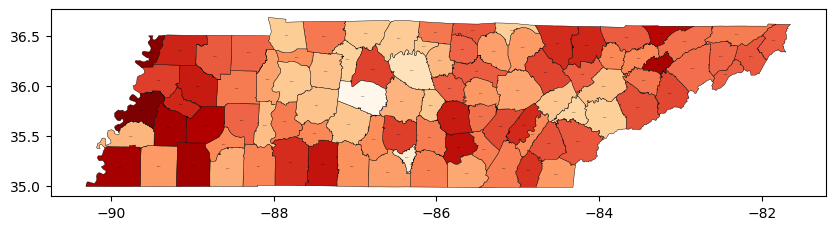

In [5]:
# Plot the data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
ax = filtered_svi_df.plot(figsize=(10, 10), column="RPL_THEMES", legend=False, cmap='OrRd', edgecolor='black',linewidth=0.3)

for idx, row in filtered_svi_df.iterrows():
    centroid = row.geometry.centroid
    county_name = row.FIPS
    ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=0.5)

# Display the plot
plt.show()

In [6]:
# checking the data type of the FIPS column
print(type(filtered_svi_df['FIPS'][0]))

<class 'str'>


In [7]:
filtered_svi_df.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry
0,47,Tennessee,TN,47001,Anderson,47001,"Anderson County, Tennessee",337.203190,76513,0,...,0.2,0.1,0.1,2.4,0.6,0.3,0.2,1.832034,0.089394,"MULTIPOLYGON (((-84.44988 36.15105, -84.44823 ..."
1,47,Tennessee,TN,47003,Bedford,47003,"Bedford County, Tennessee",473.638948,48937,0,...,0.2,0.0,0.1,2.4,0.6,0.7,0.6,1.833986,0.122174,"MULTIPOLYGON (((-86.66330 35.47122, -86.66292 ..."
2,47,Tennessee,TN,47005,Benton,47005,"Benton County, Tennessee",394.306039,16133,0,...,0.2,0.0,0.2,1.0,1.0,0.0,0.2,1.910518,0.113043,"MULTIPOLYGON (((-88.22473 35.88639, -88.21660 ..."


#### Overdose data (2020)
we need to combine Overdose data to the svi dataframe

In [8]:

# this contains mortality data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
mortality_df = pd.read_csv('./data/Mortality data/Current Final Multiple Cause of Death Data/TennesseeDeaths_2018_2021.csv')

In [9]:
# rename county code column to FIPS
mortality_df.rename(columns={'County Code':'FIPS'}, inplace=True)

In [10]:
# convert FIPS column to string
mortality_df['FIPS'] = mortality_df['FIPS'].astype(str)

In [11]:
# filtering the mortality data for year 2020
mortality_df_2020 = mortality_df[mortality_df['Year']==2020]
mortality_df_2020.reset_index(drop=True, inplace=True)

In [12]:
mortality_df_2020.head(3)

,State,County,FIPS,Year,Year Code,Deaths,Population,Crude Rate
0,TN,"Anderson County, TN",47001,2020,2020,63,77558,81.2
1,TN,"Bedford County, TN",47003,2020,2020,16,50179,Unreliable
2,TN,"Benton County, TN",47005,2020,2020,Suppressed,16131,Suppressed


In [13]:
# Assuming filtered_df has the 'od_deaths' column
od_deaths_counts = mortality_df_2020['Deaths'].value_counts()

# Print the counts of each unique value in the 'od_deaths' column
print(od_deaths_counts)

Suppressed    35
14             6
10             5
17             4
13             3
0              3
16             3
12             3
38             2
33             2
23             2
63             2
41             2
22             2
94             1
31             1
48             1
24             1
71             1
461            1
56             1
133            1
43             1
66             1
34             1
11             1
35             1
350            1
20             1
29             1
18             1
141            1
21             1
448            1
79             1
Name: Deaths, dtype: int64


In [14]:
# Merge the dataframes on the 'FIPS' column(this will include all the 2020 data for the Washington DC, Virginia, Maryland, and West Virginia(county level))
merged_df_TN = pd.merge(filtered_svi_df, mortality_df_2020[['FIPS', 'Deaths']],
                     on='FIPS', how='left')

In [ ]:

# Rename the 'Provisional Drug Overdose Deaths' column to 'od_deaths'
# merged_df.rename(columns={'Provisional Drug Overdose Deaths': 'od_deaths'}, inplace=True)

# If there are NaN values in 'od_deaths' column, you can fill them with a default value, for example, 0
# merged_df['Deaths'].fillna(0, inplace=True)

# Now, merged_df contains the new column 'od_deaths' based on matching FIPS codes

In [15]:
merged_df_TN.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry,Deaths
0,47,Tennessee,TN,47001,Anderson,47001,"Anderson County, Tennessee",337.203190,76513,0,...,0.1,0.1,2.4,0.6,0.3,0.2,1.832034,0.089394,"MULTIPOLYGON (((-84.44988 36.15105, -84.44823 ...",63
1,47,Tennessee,TN,47003,Bedford,47003,"Bedford County, Tennessee",473.638948,48937,0,...,0.0,0.1,2.4,0.6,0.7,0.6,1.833986,0.122174,"MULTIPOLYGON (((-86.66330 35.47122, -86.66292 ...",16
2,47,Tennessee,TN,47005,Benton,47005,"Benton County, Tennessee",394.306039,16133,0,...,0.0,0.2,1.0,1.0,0.0,0.2,1.910518,0.113043,"MULTIPOLYGON (((-88.22473 35.88639, -88.21660 ...",Suppressed


##### Now I need to extract specifically Washington DC Metropolitan Area SVI dataset.

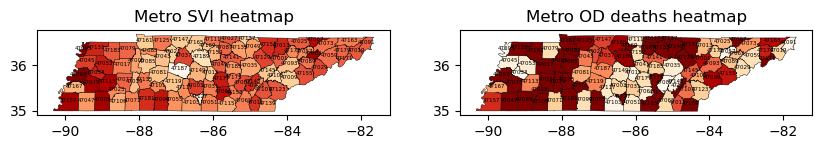

In [16]:
# Plot the data side by side using subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Plot for filtered_result (assuming filtered_result is your filtered dataframe)
ax1 = merged_df_TN.plot(ax=axes[0], column="RPL_THEMES", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax1.set_title('Metro SVI heatmap')

# Plot for filtered_merged_df (assuming filtered_merged_df is your first filtered dataframe)
ax2 = merged_df_TN.plot(ax=axes[1], column="Deaths", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax2.set_title('Metro OD deaths heatmap')

# Annotate the plots
for ax in [ax1, ax2]:
    for idx, row in merged_df_TN.iterrows():
        centroid = row.geometry.centroid
        county_name = row.FIPS
        ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=4)

# Display the plots
plt.show()

In [17]:
# make "Suppressed" values in the Deaths column to 5   
merged_df_TN['Deaths'].replace('Suppressed', 5, inplace=True)

In [18]:
# check the data type of the Deaths column
print(type(merged_df_TN['Deaths'][0]))

<class 'str'>


In [19]:
# convert Deaths column to float
merged_df_TN['Deaths'] = merged_df_TN['Deaths'].astype(float)

In [20]:
# create a new column 'od_deaths_per_1000' which is the ratio of 'od_deaths' to 'E_TOTPOP' and multiply by 1000
merged_df_TN['od_deaths_per_1000'] = (merged_df_TN['Deaths']/merged_df_TN['E_TOTPOP'])*1000

In [21]:
merged_df_TN

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry,Deaths,od_deaths_per_1000
0,47,Tennessee,TN,47001,Anderson,47001,"Anderson County, Tennessee",337.203190,76513,0,...,0.1,2.4,0.6,0.3,0.2,1.832034,0.089394,"MULTIPOLYGON (((-84.44988 36.15105, -84.44823 ...",63.0,0.823389
1,47,Tennessee,TN,47003,Bedford,47003,"Bedford County, Tennessee",473.638948,48937,0,...,0.1,2.4,0.6,0.7,0.6,1.833986,0.122174,"MULTIPOLYGON (((-86.66330 35.47122, -86.66292 ...",16.0,0.326951
2,47,Tennessee,TN,47005,Benton,47005,"Benton County, Tennessee",394.306039,16133,0,...,0.2,1.0,1.0,0.0,0.2,1.910518,0.113043,"MULTIPOLYGON (((-88.22473 35.88639, -88.21660 ...",5.0,0.309924
3,47,Tennessee,TN,47007,Bledsoe,47007,"Bledsoe County, Tennessee",406.555162,14961,0,...,0.3,1.6,0.8,0.2,0.2,1.751700,0.104806,"MULTIPOLYGON (((-85.43618 35.54216, -85.43395 ...",0.0,0.000000
4,47,Tennessee,TN,47009,Blount,47009,"Blount County, Tennessee",558.819446,131641,0,...,0.1,2.3,0.3,0.1,0.1,2.210668,0.146114,"MULTIPOLYGON (((-84.18832 35.61055, -84.18540 ...",66.0,0.501364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,47,Tennessee,TN,47181,Wayne,47181,"Wayne County, Tennessee",734.108836,16638,0,...,0.2,1.7,0.7,0.1,0.1,2.002053,0.188684,"MULTIPOLYGON (((-88.02474 35.39231, -88.02023 ...",5.0,0.300517
91,47,Tennessee,TN,47183,Weakley,47183,"Weakley County, Tennessee",580.352927,33377,0,...,0.1,1.4,0.5,0.1,0.2,1.847894,0.151140,"MULTIPOLYGON (((-88.95977 36.22393, -88.95661 ...",5.0,0.149804
92,47,Tennessee,TN,47185,White,47185,"White County, Tennessee",376.678064,27087,0,...,0.1,1.9,0.5,0.0,0.1,1.848707,0.098142,"MULTIPOLYGON (((-85.68289 35.82936, -85.68209 ...",17.0,0.627607
93,47,Tennessee,TN,47187,Williamson,47187,"Williamson County, Tennessee",582.862359,232380,0,...,0.1,2.3,0.4,0.3,0.2,2.093451,0.150994,"MULTIPOLYGON (((-87.21220 35.86736, -87.20507 ...",31.0,0.133402


#### Saving dataframe to a shapefile

In [22]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_df_TN, geometry='geometry')

In [23]:

# Save the GeoDataFrame to a Shapefile
gdf.to_file("./data/processed data/SVI2020 TN counties with death rate/SVI2020_TN_counties_with_death_rate.shp", driver='ESRI Shapefile')

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_42440/70149662.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("./data/processed data/SVI2020 TN counties with death rate/SVI2020_TN_counties_with_death_rate.shp", driver='ESRI Shapefile')


#### Taking all the variables

In [ ]:
selectedVariables = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','od_deaths_per_1000']

In [ ]:
selectedVariablesWithoutY = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']